# MultiNest sampling

This example demonstrates how to use MultiNest sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "MultiNest: an efficient and robust Bayesian inference tool for cosmology and particle physics."
Feroz, F., M. P. Hobson, and M. Bridges. Monthly Notices of the Royal Astronomical Society 398.4 (2009): 1601-1614.

First create fake data.

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Create the nested sampler that will be used to sample from the posterior.

In [5]:
# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedController(log_likelihood, log_prior, method=pints.MultinestSampler)

# Set number of iterations
sampler.set_iterations(8000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(1600)

sampler._sampler.set_f_s_threshold(2.0)

Run the sampler!

In [6]:
samples = sampler.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 8000
Total number of posterior samples: 1600
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.0 -inf          1               0             
0     221     

2120  3391    5:22.4 -1126.639492  0.708793046     1             
2140  3416    5:22.4 -1108.934494  0.709549071618  1             
2160  3446    5:22.5 -1094.809807  0.709126724     1             
2180  3475    5:22.6 -1081.25946   0.708943089     1             
2200  3502    5:22.7 -1068.407602  0.709219858156  1             
2220  3534    5:23.2 -1051.173898  0.708359923     1             
2240  3570    5:27.4 -1037.00024   0.706624606     6             
2260  3594    5:34.6 -1107.190202  0.707576706     7             
2280  3623    5:44.8 -1177.183814  0.707415451     6             
2300  3654    5:56.1 -1159.05043   0.706822372     7             
2320  3685    6:04.9 -1146.50582   0.706240487     1             
2340  3713    6:07.0 -1135.841739  0.706308482     6             
2360  3737    6:14.3 -1193.25607   0.707222056     7             
2380  3775    6:27.5 -1175.380155  0.705185185     7             
2400  3805    6:36.5 -1157.114797  0.704845814978  5             
2420  3828

4640  6841   12:59.2 -110.0145555  0.720385033     6             
4660  6866   13:02.5 -106.5285184  0.720692855     1             
4680  6889   13:02.7 -102.7285132  0.721220527     1             
4700  6916   13:02.8 -99.919731    0.721301412     1             
4720  6943   13:03.1 -96.05954776  0.721381629     1             
4740  6965   13:03.1 -93.09496611  0.722010663     1             
4760  6991   13:03.1 -89.80328866  0.722196935     1             
4780  7015   13:03.3 -85.96215198  0.722600151     1             
4800  7040   13:03.5 -83.92446419  0.722891566     1             
4820  7069   13:03.5 -80.57399693  0.722747039     1             
4840  7096   13:03.5 -77.7522747   0.722819594     1             
4860  7120   13:03.6 -75.75890451  0.723214286     1             
4880  7150   13:03.8 -73.37596322  0.722962962963  1             
4900  7188   13:03.8 -70.59084932  0.72186211      1             
4920  7218   13:04.0 -68.47560855  0.721619243     1             
4940  7248

7140  10257  13:10.8 -1.563337757  0.724358324     1             
7160  10285  13:11.0 -1.493965171  0.724329793     1             
7180  10311  13:11.0 -1.427059314  0.724447583     1             
7200  10333  13:11.2 -1.362223326  0.72485653881   1             
7220  10354  13:11.3 -1.300002568  0.725336548     1             
7240  10377  13:11.3 -1.239607846  0.725669039     1             
7260  10404  13:11.3 -1.181599477  0.725709716     1             
7280  10427  13:11.4 -1.125923805  0.726039693     1             
7300  10459  13:11.4 -1.092125035  0.725718262     1             
7320  10485  13:11.4 -1.040439194  0.725830441     1             
7340  10516  13:11.5 -0.9907       0.72558323448   1             
7360  10547  13:11.5 -0.943094     0.725337538     1             
7380  10575  13:11.7 -0.897576     0.725307125     1             
7400  10601  13:12.1 -0.854086     0.725419077     1             
7420  10629  13:12.1 -0.812533875  0.725388601     1             
7440  1066

## Plot posterior samples versus true parameter values (dashed lines)

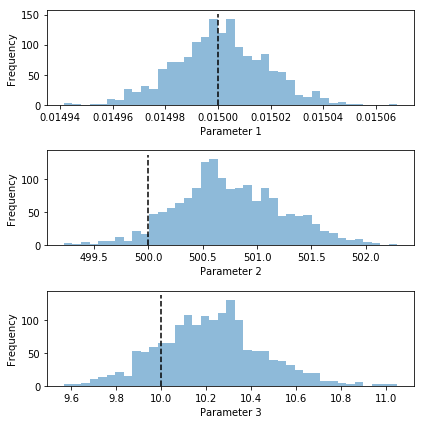

In [8]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=real_parameters)

plt.show()

## Plot posterior predictive simulations versus the observed data

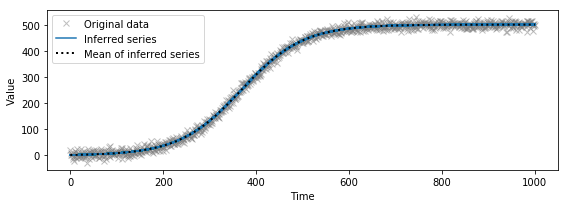

In [9]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [10]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -3759.56221529 ± 0.0854467515875


## Effective sample size

In [11]:
print('effective sample size = ' + str(sampler.effective_sample_size()))

effective sample size = 1589.50265609


# Egg box problem

In [12]:
class ExampleToy(pints.LogPDF):
    def __init__(self, sigma, r):
        self._sigma = sigma
        self._r = r
        self._log_toy = pints.toy.SimpleEggBoxLogPDF(self._sigma, self._r)

    def __call__(self, x):
        x1 = np.copy(x)
        x1[0] = -15 + 30 * x[0]
        x1[1] = -15 + 30 * x[1]
        return self._log_toy(x1)

    def n_parameters(self):
        return 2

In [13]:
log_pdf = ExampleToy(2, 4)
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

In [14]:
sampler = pints.NestedController(log_pdf, log_prior, method=pints.MultinestSampler)

# Set number of iterations
sampler.set_iterations(8000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(1600)

sampler._sampler.set_f_s_threshold(1.3)

In [15]:
samples = sampler.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 8000
Total number of posterior samples: 1600
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.1 -inf          1               0             
0     221     

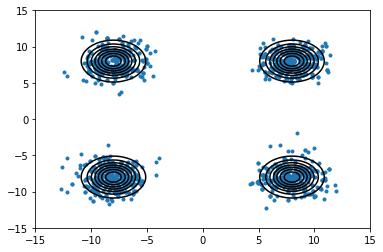

In [16]:
sigma = 2
r = 4
log_pdf = pints.toy.SimpleEggBoxLogPDF(sigma, r)

# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
Z = [[np.exp(log_pdf([i, j])) for i in x] for j in y]

plt.figure()
plt.contour(X, Y, Z, colors='k')
plt.scatter(-15 + 30 * samples[:, 0], -15 + 30 * samples[:, 1], marker='.')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

In [17]:
print('effective sample size = ' + str(sampler.effective_sample_size()))

effective sample size = 1318.73082906


In [18]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -5.33334731453 ± 0.0581106261496
